In [1]:
import numpy as np
import os
import platform
import cv2
import matplotlib.pyplot as plt
import time
from math import log10, sqrt


## Defined Functions

In [2]:
def image2double(img):
    if (img.dtype != np.uint8):
        raise ValueError("ValueError exception thrown!\n \
                         \r\tInput img should be of dtype uint8.")
    return img.astype(float) / (np.iinfo(img.dtype).max - np.iinfo(img.dtype).min)
def image2uint8(img):
    if (img.dtype != float):
        raise ValueError("ValueError exception thrown!\n \
                         \r\tInput img should be of dtype float.")
    return (255*img).astype(np.uint8)

def PSNR(original, compressed):
    # MSE: the mean squared error
    mse = np.mean((original - compressed) ** 2)
    # MSE of zero means there is no noise present in the signal
    if(mse == 0):  
        return float("inf")
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def display_images(img_fullname, img, img_reconstructed, psnr, title = None):
    h, w =  img.shape
    if (w < 250):
        h = h * 250//w 
        w = 250
        img = cv2.resize(img, dsize=(h, w))
        img_reconstructed = cv2.resize(img_reconstructed, dsize=(h, w))
    font = cv2.FONT_HERSHEY_SIMPLEX
    title_img_height = 200
    title_img = np.ones((title_img_height, 2*w+90))
    title_img =  cv2.putText(title_img, 'Original Image', (80, int(title_img_height/2)), font, 3, (0, 0, 0), 5, cv2.LINE_AA)
    title_img_names = cv2.putText(title_img, 'Reconstructed Image', (w+100, int(title_img_height/2)), font, 3, (0, 0, 0), 5, cv2.LINE_AA)
    title_img_psnr = cv2.putText(np.ones((title_img_height, 2*w+90)), f'PSNR: {psnr}', (20, int(title_img_height/2)), font, 3, (0, 0, 0), 5, cv2.LINE_AA)
    
    img_or = np.concatenate((
                    np.concatenate((np.ones((h, 20)), img), axis=1), 
                    np.ones((h, 50)), 
                    np.concatenate((img_reconstructed, np.ones((h, 20))), axis=1)
                    ), 
                    axis=1
                    )
    
    img_or_t = np.concatenate((
                    title_img_names,
                    img_or,
                    title_img_psnr
                ),
                axis=0
            )
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img_or_t, cmap='gray')
#     plt.show()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    if title:
        ax.title.set_text(str(title))
    ax.imshow(img_or_t, cmap='gray')
    return fig


## Read our one image as dataset

Creating Database

Datebase of size (1080, 2400)
DB:
[[0.68235294 0.69019608 0.6745098  ... 0.21960784 0.29803922 0.29411765]
 [0.68627451 0.68235294 0.66666667 ... 0.21960784 0.28235294 0.29803922]
 [0.69411765 0.67058824 0.65882353 ... 0.18039216 0.20392157 0.21960784]
 ...
 [0.6745098  0.67058824 0.67058824 ... 0.22352941 0.23529412 0.23137255]
 [0.67843137 0.6745098  0.6745098  ... 0.23529412 0.24705882 0.25490196]
 [0.69411765 0.68627451 0.68627451 ... 0.25490196 0.25490196 0.27058824]]


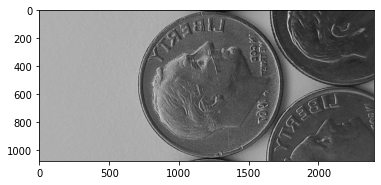

In [3]:
slash = '\\' if platform.system() == 'Windows' else '/'

img_fullname = f'.{slash}One-image-database{slash}one-dime.jpg'
img_fullname_output = f'.{slash}One-image-database{slash}one-dime-output.jpg'
    
print('Creating Database')
img_itr = cv2.imread(img_fullname, cv2.IMREAD_GRAYSCALE)
DB_img_size = img_itr.T.shape
img_itr = image2double(img_itr)
DB = img_itr.T

print()
print(f"Datebase of size {DB.shape}")
print("DB:")
print(DB)
plt.imshow(DB, cmap="gray")
plt.show()

## Calculate and save mean of columns of DB

In [4]:
# calculate and save mean of columns of DB.
print("Calculating and Saving mean of columns in DB.")
DB_mean = np.mean(DB, axis=0)
print()

print(f"Mean of columns in DB. This vetor has {DB_mean.size} elements")
print(DB_mean)
print()
print("Zero-ing mean of columns in DB")
DB = DB - DB_mean
print("Mean of columns in DB is now zero." \
      if not np.any(np.mean(DB, axis=0)>1e-15) else \
     "There seem to be a problem. please run the code again!")
print()
print(f"Datebase of size {DB.shape}")
print("DB:")
print(DB)

Calculating and Saving mean of columns in DB.

Mean of columns in DB. This vetor has 2400 elements
[0.67475672 0.67530138 0.67614379 ... 0.25820988 0.2571968  0.25708424]

Zero-ing mean of columns in DB
Mean of columns in DB is now zero.

Datebase of size (1080, 2400)
DB:
[[ 0.00759622  0.0148947  -0.00163399 ... -0.03860203  0.04084241
   0.03703341]
 [ 0.01151779  0.00705156 -0.00947712 ... -0.03860203  0.02515614
   0.04095497]
 [ 0.01936093 -0.00471314 -0.01732026 ... -0.07781772 -0.05327524
  -0.0374764 ]
 ...
 [-0.00024691 -0.00471314 -0.00555556 ... -0.03468046 -0.02190269
  -0.02571169]
 [ 0.00367466 -0.00079158 -0.00163399 ... -0.02291576 -0.01013798
  -0.00218228]
 [ 0.01936093  0.01097313  0.01013072 ... -0.00330792 -0.00229484
   0.01350399]]


## Calculate covariance of columns

In [5]:
# calculate covariance of columns
print("Calculating covariance of columns in DB, to see how they change in respect to one another.\n")
Cov_DB = np.cov(DB.T)
print("Covariance of columns in DB:")
print(f"Shape of covariance of columns in DB is {Cov_DB.shape}")
print(Cov_DB)

Calculating covariance of columns in DB, to see how they change in respect to one another.

Covariance of columns in DB:
Shape of covariance of columns in DB is (2400, 2400)
[[ 4.59105071e-04  2.39649384e-04  1.31505230e-05 ... -7.42191088e-05
  -9.57469141e-05 -1.31008865e-04]
 [ 2.39649384e-04  3.56403826e-04  2.74367514e-04 ...  6.05614788e-05
   3.68351893e-05  1.93935110e-05]
 [ 1.31505230e-05  2.74367514e-04  4.35827241e-04 ...  6.35731344e-05
   4.41644732e-05  6.04684137e-05]
 ...
 [-7.42191088e-05  6.05614788e-05  6.35731344e-05 ...  8.19900743e-03
   8.16450643e-03  7.69287132e-03]
 [-9.57469141e-05  3.68351893e-05  4.41644732e-05 ...  8.16450643e-03
   8.53510984e-03  8.23449317e-03]
 [-1.31008865e-04  1.93935110e-05  6.04684137e-05 ...  7.69287132e-03
   8.23449317e-03  8.43756970e-03]]


## calculate eigen vectors and eigen values of covariance of columns

In [6]:
# calculate eigen vectors and eigen values of covariance of columns
print('Calculating Eigen Vectors and Eigen Values\n')
[eigenValues, eigenVectors] = np.linalg.eigh(Cov_DB)
print("Sorting eigen vectors by the magnitude of their corresponding eigen value.")
sort_index     = eigenValues.argsort()[::-1] # Descending Order
eigenValues    = eigenValues[sort_index]
eigenVectors   = eigenVectors[:, sort_index]
print()
print(f"Eigen values of size {eigenValues.size}: \n{eigenValues}")
print()
print(f"corresponding eigen vectors of shape {eigenVectors.shape}: \n{eigenVectors}")


Calculating Eigen Vectors and Eigen Values

Sorting eigen vectors by the magnitude of their corresponding eigen value.

Eigen values of size 2400: 
[ 5.87887847e+00  3.19926010e+00  1.43763078e+00 ... -4.19204831e-16
 -5.15023660e-16 -1.11602679e-15]

corresponding eigen vectors of shape (2400, 2400): 
[[ 2.83404955e-04 -4.10288838e-04 -1.26785754e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.48001539e-04 -4.47555719e-04 -1.06231432e-03 ... -6.44865410e-02
   2.73925206e-02 -2.39067861e-01]
 [-6.99945918e-04 -7.69748933e-04 -8.47536429e-04 ... -3.41790612e-03
   5.01844383e-02  3.13523592e-01]
 ...
 [-1.86680279e-02  1.99300884e-02 -1.28812383e-02 ...  3.34195948e-02
   2.37999132e-02 -1.73109025e-02]
 [-1.94891745e-02  2.09091687e-02 -1.38105178e-02 ... -1.49512363e-02
   9.09394346e-03 -6.49351966e-03]
 [-1.98841857e-02  2.10349186e-02 -1.42683983e-02 ... -5.51433254e-04
  -2.66972098e-03  3.30865106e-02]]


## A closer look at eigen values 1

20 elements of eigen values from 1070 to 1090:
[4.36684913e-06 4.33510042e-06 4.18655644e-06 4.05568886e-06
 4.00495332e-06 3.80856949e-06 3.71564926e-06 3.56641976e-06
 3.13242589e-06 3.66630253e-16 3.08245310e-16 2.89445475e-16
 2.63370273e-16 2.55446179e-16 2.35108075e-16 1.86091894e-16
 1.80974419e-16 1.76030934e-16 1.68715094e-16 1.58259374e-16]

Dividing each eigen value by the next one, to see how each element changes from 1070 to 1090:
[1.00732364e+00 1.03548118e+00 1.03226766e+00 1.01266820e+00
 1.05156367e+00 1.02500781e+00 1.04184294e+00 1.13854881e+00
 8.54382818e+09 1.18941065e+00 1.06495121e+00 1.09900587e+00
 1.03102060e+00 1.08650534e+00 1.26339772e+00 1.02827734e+00
 1.02808305e+00 1.04336209e+00 1.06606699e+00 1.03994449e+00]

Maximum change happens after the 1079th element of eigen values: 3.132425887953175e-06


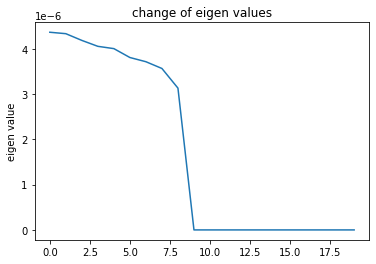

In [7]:
print(f"20 elements of eigen values from 1070 to 1090:\n{eigenValues[1070:1090]}")
print()

eigenValues_divide_by_next = np.true_divide(eigenValues[:-1], eigenValues[1:])
print(f"Dividing each eigen value by the next one, to see how each element changes from 1070 to 1090:\n{eigenValues_divide_by_next[1070:1090]}")
print()
print(f"Maximum change happens after the {np.argmax(eigenValues_divide_by_next)+1}th element of eigen values: {eigenValues[np.argmax(eigenValues_divide_by_next)]}")

plt.figure(1)
plt.plot(eigenValues[1070:1090])
plt.ylabel("eigen value")
plt.title("change of eigen values")
plt.show()


## A closer look at eigen values 2

Another approach consist of defining a cover rate, which represents what percentage of eigen values we want to consider.

Our cover rate is 0.99%


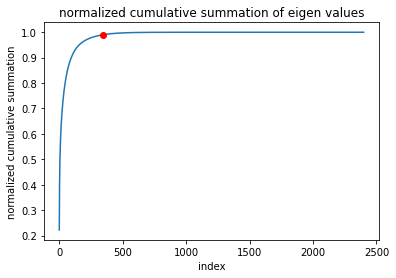

In [8]:
print(f"Another approach consist of defining a cover rate, which represents what percentage of eigen values we want to consider.")
print()
cover_rate = 0.99
print(f"Our cover rate is {cover_rate}%")
index_at_cover_rate = np.argmin(abs(np.cumsum(eigenValues) - cover_rate*np.sum(eigenValues)))


plt.figure(1)
plt.plot(np.cumsum(eigenValues)/np.sum(eigenValues))
plt.plot(index_at_cover_rate, cover_rate, 'o', color='r')
plt.ylabel("normalized cumulative summation")
plt.xlabel("index")
plt.title("normalized cumulative summation of eigen values")
plt.show()


## Extraction of important Eigen vectors

In [9]:
newFeatureVectors = eigenVectors[:, :index_at_cover_rate+1]
newFeatureValues  = eigenValues[:index_at_cover_rate+1]
print()
print(f"Eigen values that are kept of size {newFeatureValues.size}: \n{newFeatureValues}")
print()
print(f"Corresponding eigen vectors of shape {newFeatureVectors.shape}: \n{newFeatureVectors}")


Eigen values that are kept of size 343: 
[5.87887847e+00 3.19926010e+00 1.43763078e+00 1.07352148e+00
 8.23900444e-01 7.63105896e-01 5.35675773e-01 5.16658897e-01
 4.17543520e-01 3.91769111e-01 3.54265063e-01 3.25570370e-01
 3.11661914e-01 2.82130347e-01 2.65485510e-01 2.56227531e-01
 2.24180150e-01 2.18917004e-01 2.14155921e-01 2.01195992e-01
 1.94593899e-01 1.79926244e-01 1.76601045e-01 1.71399367e-01
 1.64332324e-01 1.58507132e-01 1.56761587e-01 1.49935493e-01
 1.47927083e-01 1.45813537e-01 1.35662748e-01 1.34143138e-01
 1.25156887e-01 1.23039829e-01 1.19019416e-01 1.18121219e-01
 1.13406353e-01 1.11501996e-01 1.03327170e-01 1.02172638e-01
 1.01879149e-01 9.78306675e-02 9.53942954e-02 9.32759214e-02
 9.18675279e-02 9.02391292e-02 8.62746494e-02 8.59871874e-02
 8.51500340e-02 8.33602172e-02 8.19925087e-02 7.96663118e-02
 7.91072644e-02 7.52930480e-02 7.32906237e-02 7.20060245e-02
 7.02610263e-02 6.74157347e-02 6.64154622e-02 6.54423844e-02
 6.45100521e-02 6.32806643e-02 6.12112572e-

## Calculation of princial components of DB

In [10]:
print(f"DB of shape {DB.shape} is manipulated in way that its unimportant elements are discarded, and then transformed into a new space by multiplying it by the non-discarded eigen vectors.")
print()
newDB_Principal_components = np.matmul(DB, newFeatureVectors)
print(f"DB after removing it's unimportant vectors: \nshape of new DB is {newDB_Principal_components.shape}\n{newDB_Principal_components}")
print()
print(f"This new DB of size {newDB_Principal_components.shape} encapsulates all the important features existing in the original DB of size {DB.shape}")

DB of shape (1080, 2400) is manipulated in way that its unimportant elements are discarded, and then transformed into a new space by multiplying it by the non-discarded eigen vectors.

DB after removing it's unimportant vectors: 
shape of new DB is (1080, 343)
[[ 4.20508451e+00  2.04717859e+00  1.29193628e+00 ... -4.02030018e-02
  -3.92425266e-02 -4.36613603e-02]
 [ 4.17589564e+00  2.26547665e+00  1.38961126e+00 ...  2.02678572e-02
   4.82424431e-02  3.96871710e-04]
 [ 4.15516388e+00  2.45426099e+00  1.61295963e+00 ...  3.55356354e-02
   6.13861417e-02  5.16458107e-02]
 ...
 [ 3.21952251e+00  2.67751692e+00  1.13902924e+00 ...  2.15077379e-02
  -5.56602995e-02  2.47451257e-02]
 [ 3.20953561e+00  2.55905833e+00  1.02418362e+00 ...  4.40093863e-02
  -3.89347775e-02  3.86190277e-02]
 [ 3.14121967e+00  2.48456652e+00  9.15708727e-01 ...  5.20818283e-02
   8.37089040e-03 -3.38948191e-03]]

This new DB of size (1080, 343) encapsulates all the important features existing in the original DB of

## Reconstruction of DB from principal components of DB

In [11]:
print(f"Reconstructing DB by again multiplying it by non-discarded eigen vectors to transform it back to the original space.")
newDB_Reconstructed = np.matmul(newDB_Principal_components, newFeatureVectors.T) + DB_mean
print()
print(f"Reconstructed DB of shape {newDB_Reconstructed.shape}: \n{newDB_Reconstructed}")
print()
print("De-zero-ed mean of the original DB")
DB = DB + DB_mean
print()

Reconstructing DB by again multiplying it by non-discarded eigen vectors to transform it back to the original space.

Reconstructed DB of shape (1080, 2400): 
[[0.68373223 0.69091849 0.66771941 ... 0.22236403 0.29439371 0.3085304 ]
 [0.68032409 0.68216423 0.66512021 ... 0.22097884 0.27733838 0.28539215]
 [0.68282692 0.67386821 0.66504045 ... 0.20026516 0.22686234 0.23002087]
 ...
 [0.67668235 0.67012364 0.67284359 ... 0.23360635 0.24574906 0.24909244]
 [0.68790824 0.67994193 0.68153595 ... 0.23581903 0.25034408 0.25867456]
 [0.69061073 0.68705189 0.68785442 ... 0.2474838  0.26591832 0.27852097]]

De-zero-ed mean of the original DB



img_fullname, 	psnr: 87.71091074581878 dB


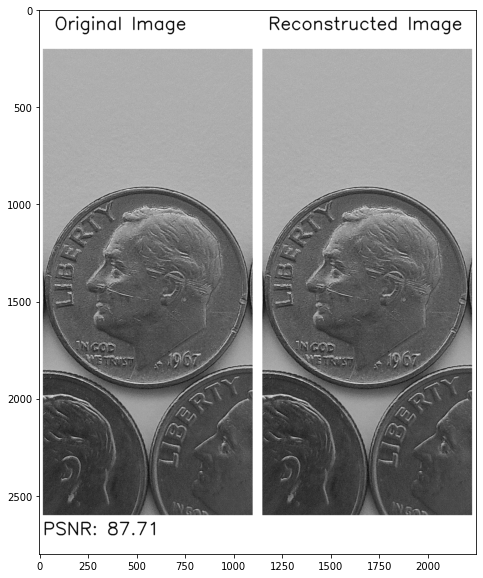

In [12]:
# Original image
img = DB.T
# Reconstructed image
img_newReconstructed = newDB_Reconstructed.T

# Calculating psnr, peak signal-to-noise ratio, to have a quantivative comparison of images.
# PSNR is most commonly used to estimate the efficiency of compressors, filters, etc.
# The larger the value of PSNR, the more efficient is a corresponding compression or filter method.
psnr = PSNR(img_newReconstructed, img)
print(f"img_fullname, \tpsnr: {psnr} dB")
cv2.imwrite(img_fullname_output, image2uint8(img_newReconstructed))

_ = display_images(img_fullname, img, img_newReconstructed, round(psnr, 2))

In [13]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [14]:
def draw(cover_rate):
    global DB
    plt.close('all')    
    index_at_cover_rate = np.argmin(abs(np.cumsum(eigenValues, dtype=np.float64) - cover_rate*np.sum(eigenValues, dtype=np.float64)))

    newFeatureVectors = eigenVectors[:, :index_at_cover_rate+1]
    newFeatureValues  = eigenValues[:index_at_cover_rate+1]
    
    DB = DB - DB_mean
    
    # Calculate principal components of DB
    newDB_Principal_components = np.matmul(DB, newFeatureVectors)

    # Reconstruct DB from principal components of DB
    newDB_Reconstructed = np.matmul(newDB_Principal_components, newFeatureVectors.T) + DB_mean
    DB = DB + DB_mean
    # Original image
    img = DB.T
    # Reconstructed image
    img_newReconstructed = newDB_Reconstructed.T
    psnr = PSNR(img_newReconstructed, img)
    
    print(f"Cover rate is {cover_rate:04.4f}%. DB of size {DB.shape} with principal components of size {newDB_Principal_components.shape}")
    fig = display_images(img_fullname, img, img_newReconstructed, round(psnr, 2), title = f"cover rate: {cover_rate:04.4f}% \nsize of DB {DB.shape}, \nsize of principal components of DB {newDB_Principal_components.shape}")
#     figure_output_dest = f".{slash}One-image-database-Figures{slash}figure-{cover_rate:04.4f}.jpg"
#     fig.savefig(figure_output_dest)

In [15]:
interact(draw, cover_rate=widgets.FloatSlider(min=0.5, max=1, step=1e-4, value=0.5,  continuous_update=False, readout_format='.4f'));

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='cover_rate', max=1.0, min=0…

In [20]:
from IPython.display import HTML

HTML(f"""
    <video alt="test" controls>
        <source src=".{slash}One-image-database-Figures{slash}Timelapse-Figures.mp4" type="video/mp4">
    </video>
""")